# Behavioral Cloning Project Using Generators

## Read CSV File

In [1]:
import os
import csv

samples = []
with open('./recording16_11/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

## Train, Validation   Split 

In [2]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

## Train and Validation Generators

In [3]:
import cv2
import sklearn

def generator(samples, batch_size=32, flip_center=True, side_cams=True , correction=1):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                if flip_center:
                    flip_center_image = cv2.flip(center_image, 1)
                    flip_center_angle = -1 * center_angle
                    images.append(flip_center_image)
                    angles.append(flip_center_angle)
                if side_cams:
                    name = batch_sample[1]
                    left_image = cv2.imread(name)
                    left_angle = float(batch_sample[3])
                    images.append(left_image)
                    angles.append(left_angle + correction)
                    name = batch_sample[2]
                    right_image = cv2.imread(name)
                    right_angle = float(batch_sample[3])
                    images.append(right_image)
                    angles.append(right_angle - correction)

                # trim image to only see section with road
                X_train = np.array(images)
                y_train = np.array(angles)
                X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
                #print("size of generator output:", y_train.size)
                yield X_train, y_train


In [4]:
# Set batch size
batch_size= 128

In [5]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [7]:
import multiprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
import numpy as np
import math

In [8]:
def train_model():
    model = Sequential()
    
    # crop top and bottom
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    
    # normalize data
    model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(160,320,3)))
    
    # 1. convolution layer
    model.add(Convolution2D(24, 5,  activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.7))
    
    # 2. convolution layer
    model.add(Convolution2D(36, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))
    
    # 3. convolution layer
    model.add(Convolution2D(48, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    
    # 4. convolution layer
    model.add(Convolution2D(64, 3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history_object = model.fit(train_generator, 
                        steps_per_epoch=math.ceil(len(train_samples)/batch_size), 
                        validation_data=validation_generator, 
                        validation_steps=math.ceil(len(validation_samples)/batch_size), 
                        epochs=5, verbose=1,  workers=6, use_multiprocessing=True ) # 
    model.save('model_with_generators_v1.h5')
    return history_object

## Train and Plot Accuracies

In [9]:
# train and save history
history_object= train_model()

Epoch 1/5
26/26 [==============================] - 5s 186ms/step - loss: 1.0891 - val_loss: 0.5021
Epoch 2/5
26/26 [==============================] - 8s 317ms/step - loss: 0.5003 - val_loss: 0.5023
Epoch 3/5
26/26 [==============================] - 12s 458ms/step - loss: 0.4914 - val_loss: 0.4969
Epoch 4/5
26/26 [==============================] - 16s 619ms/step - loss: 0.4094 - val_loss: 0.4682
Epoch 5/5
26/26 [==============================] - 19s 736ms/step - loss: 0.3124 - val_loss: 0.4560


dict_keys(['loss', 'val_loss'])


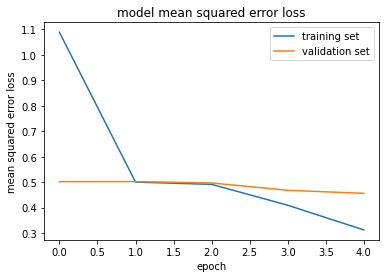

In [10]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
import matplotlib.pyplot as plt
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
    
p = multiprocessing.Process(target=train_model)
p.start()
p.join()